# **xwOBA Model**

# Part 1 - Data collection

In [1]:
from pybaseball import statcast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

For this project, I'll be using three years of data. This way it is recent, but is still measured **prior** to the 2023 rule changes.

In [2]:
three_year_data = statcast(start_dt="2020-07-23", end_dt="2022-11-05")

This is a large query, it may take a moment to complete


C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates
Skipping offseason dates


100%|████████████████████████████████████████████████████████████████████████████████| 579/579 [10:30<00:00,  1.09s/it]


Since I'm designing a process to find **xwOBAcon**, I'm only using balls in play.

In [3]:
contact_data = three_year_data[three_year_data['description'] == 'hit_into_play']
contact_data

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
193,SL,2022-11-05,89.2,-0.06,6.14,"Pressly, Ryan",592206,519151,field_out,hit_into_play,...,4,1,4,1,4,Standard,Standard,137,0.011,-0.219
204,FF,2022-11-05,93.9,-0.18,5.94,"Pressly, Ryan",547180,519151,field_out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,210,0.022,-0.3
211,FF,2022-11-05,93.0,-0.09,5.97,"Pressly, Ryan",592663,519151,single,hit_into_play,...,4,1,4,1,4,Standard,Standard,212,-0.02,0.262
215,SL,2022-11-05,88.1,-0.15,6.03,"Pressly, Ryan",656555,519151,field_out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,120,0.018,-0.158
139,KC,2022-11-05,86.4,-2.67,5.86,"Robertson, David",663656,502085,field_out,hit_into_play,...,1,1,4,4,1,Infield shift,Standard,47,-0.001,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,FF,2020-07-23,96.4,-1.94,5.56,"Cole, Gerrit",607208,543037,field_out,hit_into_play,...,2,2,0,0,2,Standard,Standard,225,-0.022,-0.414
256,FF,2020-07-23,95.9,-3.16,5.49,"Scherzer, Max",519317,453286,home_run,hit_into_play,...,0,2,0,2,0,Standard,Standard,222,-0.18,1.787
281,SL,2020-07-23,86.7,-3.27,5.32,"Scherzer, Max",650402,453286,field_out,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,124,0.018,-0.335
339,FF,2020-07-23,96.7,-3.26,5.44,"Scherzer, Max",592450,453286,single,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,220,-0.025,0.272


Preliminary scatter plot of exit velocity and launch angle, colored by type of ball in play.

In [4]:
contact_data = contact_data.dropna(subset = ['launch_angle', 'launch_speed'])

Text(0.5, 0, 'Exit Velocity (mph)')

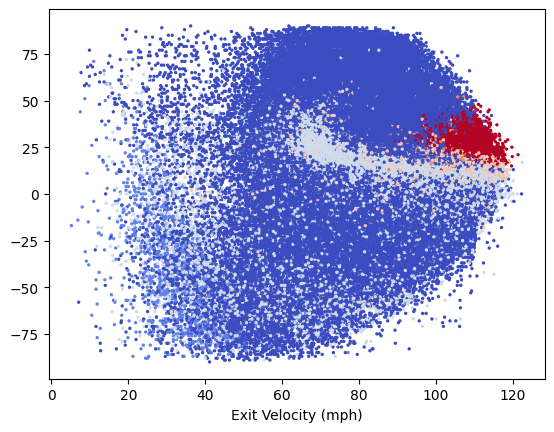

In [5]:
fig, ax = plt.subplots()
plt.scatter(x = contact_data['launch_speed'], y = contact_data['launch_angle'],
           c = contact_data['woba_value'], cmap = 'coolwarm', s = 2)
ax.set_xlabel('Exit Velocity (mph)')

To make it easier on our model, I am going to make every type of ball in play with a wOBA of 0 into "out." I also will be excluding catcher's interference because the swings were interfered with.

In [6]:
contact_data = contact_data.replace(['field_out', 'force_out', 'grounded_into_double_play', 
                                               'fielders_choice_out', 'sac_fly', 'field_error', 'sac_bunt_double_play',
                                              'fielders_choice', 'sac_bunt', 'double_play', 'triple_play',
                                              'sac_fly_double_play'], 'out')

In [7]:
contact_data.drop(contact_data[contact_data['events'] == 'catcher_interf'].index, inplace = True)

In [8]:
contact_data

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
193,SL,2022-11-05,89.2,-0.06,6.14,"Pressly, Ryan",592206,519151,out,hit_into_play,...,4,1,4,1,4,Standard,Standard,137,0.011,-0.219
204,FF,2022-11-05,93.9,-0.18,5.94,"Pressly, Ryan",547180,519151,out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,210,0.022,-0.3
211,FF,2022-11-05,93.0,-0.09,5.97,"Pressly, Ryan",592663,519151,single,hit_into_play,...,4,1,4,1,4,Standard,Standard,212,-0.02,0.262
215,SL,2022-11-05,88.1,-0.15,6.03,"Pressly, Ryan",656555,519151,out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,120,0.018,-0.158
139,KC,2022-11-05,86.4,-2.67,5.86,"Robertson, David",663656,502085,out,hit_into_play,...,1,1,4,4,1,Infield shift,Standard,47,-0.001,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,FF,2020-07-23,96.4,-1.94,5.56,"Cole, Gerrit",607208,543037,out,hit_into_play,...,2,2,0,0,2,Standard,Standard,225,-0.022,-0.414
256,FF,2020-07-23,95.9,-3.16,5.49,"Scherzer, Max",519317,453286,home_run,hit_into_play,...,0,2,0,2,0,Standard,Standard,222,-0.18,1.787
281,SL,2020-07-23,86.7,-3.27,5.32,"Scherzer, Max",650402,453286,out,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,124,0.018,-0.335
339,FF,2020-07-23,96.7,-3.26,5.44,"Scherzer, Max",592450,453286,single,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,220,-0.025,0.272


# Part 2 - Baseline model

Now that our data is set up, we can create our baseline model for xwOBAcon.

In [9]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [10]:
contact_data["events_encoded"] = [0 if x == "out" 
                                  else 1 if x == "single" 
                                  else 2 if x == "double" 
                                  else 3 if x == "triple" 
                                  else 4 for x in contact_data["events"]]

In [11]:
X = contact_data[["launch_speed", "launch_angle"]]
Y = contact_data[['events_encoded']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = .2)

We have to scale the results because exit velocity can be any positive number, while launch angle can only be between -90 and 90. This will give us a clearer, more accurate neighborhood.

In [12]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [13]:
classifier = KNeighborsClassifier(n_neighbors = 23, p = 2, metric = 'euclidean', )

In [14]:
classifier.fit(X_train, Y_train)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=23)

In [15]:
Y_pred = classifier.predict(X_test)

In [16]:
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[37453  2522   392     0   430]
 [ 5908  6408   143     0    25]
 [ 2107  1147   493     0   263]
 [  171    71    19     0    49]
 [  787     2   168     0  1961]]


In [17]:
classifier.predict_proba(X_test)

array([[0.95652174, 0.        , 0.04347826, 0.        , 0.        ],
       [0.13043478, 0.        , 0.2173913 , 0.        , 0.65217391],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       ...,
       [0.34782609, 0.13043478, 0.43478261, 0.08695652, 0.        ],
       [0.95652174, 0.04347826, 0.        , 0.        , 0.        ],
       [0.30434783, 0.        , 0.08695652, 0.        , 0.60869565]])

In [18]:
print(accuracy_score(Y_test, Y_pred))

0.7652968489234786


In [19]:
print(Y_test)

      events_encoded
2698               0
1236               2
3189               1
822                2
131                0
...              ...
503                0
1129               0
2674               1
3230               0
157                4

[60519 rows x 1 columns]


In [29]:
Y_test_binary = pd.get_dummies(contact_data["events"]).astype(int)
print(Y_test_binary)

     double  home_run  out  single  triple
193       0         0    1       0       0
204       0         0    1       0       0
211       0         0    0       1       0
215       0         0    1       0       0
139       0         0    1       0       0
..      ...       ...  ...     ...     ...
376       0         0    1       0       0
256       0         1    0       0       0
281       0         0    1       0       0
339       0         0    0       1       0
374       0         0    1       0       0

[302595 rows x 5 columns]


# Part 3 - Assessing the model

Here we will take a closer look at our model and evaluate it a little bit, starting with the log loss metric.

In [20]:
from sklearn.metrics import log_loss
Y_pred_proba = classifier.predict_proba(X_test)
log_loss(Y_test, Y_pred_proba)

1.1579459589705494

In [21]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Expected 'estimator' to be a binary classifier. Got 5 classes instead.

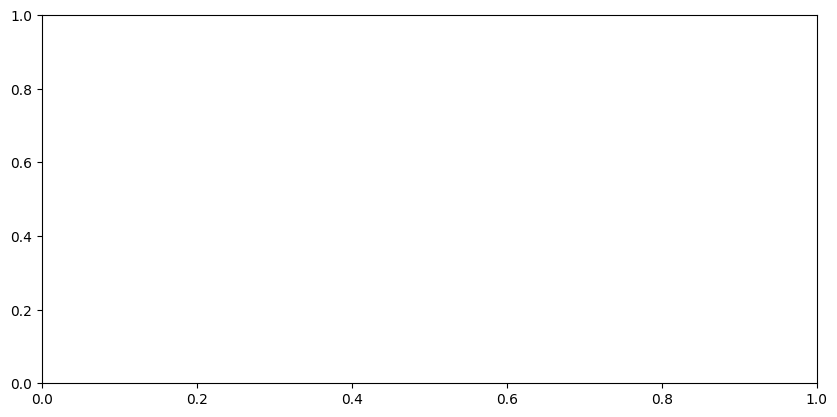

In [28]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, Y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        Y_test_binary['out'],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].Y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [23]:
X_test = pd.DataFrame(X_test, columns=["launch_speed", "launch_angle"])

In [24]:
pred_df = pd.DataFrame(classifier.predict_proba(X_test), columns=['out', 'single', 'double', 'triple', 'home_run'])
combined_df = pd.concat([X_test, pred_df], axis=1)
combined_df["output"] = list(Y_test["events_encoded"])

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [25]:
combined_df

,launch_speed,launch_angle,out,single,double,triple,home_run,output
0,-0.146316,0.504573,0.956522,0.000000,0.043478,0.000000,0.000000,0
1,0.990639,0.435779,0.130435,0.000000,0.217391,0.000000,0.652174,2
2,-0.671576,0.195002,0.000000,1.000000,0.000000,0.000000,0.000000,1
3,1.276540,0.195002,0.217391,0.086957,0.608696,0.000000,0.086957,2
4,0.744631,0.332589,0.739130,0.000000,0.173913,0.043478,0.043478,0
...,...,...,...,...,...,...,...,...
60514,-0.738064,-0.492933,0.956522,0.043478,0.000000,0.000000,0.000000,0
60515,1.256594,-0.320950,0.521739,0.391304,0.086957,0.000000,0.000000,0
60516,1.123617,0.126208,0.347826,0.130435,0.434783,0.086957,0.000000,1
60517,-0.844446,0.814143,0.956522,0.043478,0.000000,0.000000,0.000000,0
